In [1]:
import numpy as np
import scipy.io
from math import isnan
import random

In [2]:
img_dirs = ['/pio/scratch/2/i258312/imdb_crop', '/pio/scratch/2/i258312/wiki_crop']
mat_files = ['/pio/scratch/2/i258312/imdb_crop/imdb.mat', '/pio/scratch/2/i258312/wiki_crop/wiki.mat']
set_names = ['imdb', 'wiki'] # 460k, 62k

In [3]:
hdf_path = '/pio/scratch/2/i258312/faces30px.hdf5'

In [4]:
# resizing parameters
size = 30
margin = int(0.25*size)
before_crop = size+2*margin

In [5]:
from scipy import misc

def read(base_dir, filename):
    im = misc.imread(base_dir+'/'+filename[0], mode='RGB')
    return im

In [6]:
from skimage.transform import resize
from skimage.util import crop

def smaller(im):
    im = resize(im, (before_crop, before_crop, 3), mode='edge')
    im = crop(im, ((margin, margin), (margin, margin), (0,0)))
    return im

In [7]:
import re
from datetime import date

def extract_age(filename, year_taken):
    filename = filename[0]
    match = re.search('(\d\d\d\d)-(\d+)-(\d+)',filename)
    if match:
        y = int(match.group(1))
        m = int(match.group(2))
        d = int(match.group(3))
        
        # some dates are broken
        try:
            born = date(y,m,d)
        except ValueError:
            print(filename)
            try:
                born = date(y,m,15)
            except ValueError:
                born = date(y,7,15)
                
        taken = date(year_taken,7,1)
        return (taken - born).days / 365
    else:
        print(filename)
        return None

In [8]:
img = []
sex = []
age = []
n = 0

In [9]:
# load the data
for (img_dir, mat, set_name) in zip(img_dirs, mat_files, set_names):
    # load metadata
    mat_data = scipy.io.loadmat(mat)
    data_table = mat_data[set_name][0][0]
    
    # extract info
    y = data_table[1][0,:]
    f = data_table[2][0,:]
    s = data_table[3][0,:]
    #names = data_table[4][0,:]
    #print(len(f))
    
    for (filename, year, curr_sex) in zip(f,y,s):
        # calculate age
        a = extract_age(filename, year)
        if (a is not None) and (a < 160) and (a >= 0):
            age.append(a)
        else:
            continue
    
        # load and resize image
        i = read(img_dir, filename)
        i = smaller(i)
        img.append(i)
        
        # get rid of nans in sex
        if isnan(curr_sex):
            curr_sex = random.choice([1.0, 0.0])
        curr_sex = bool(curr_sex)
        sex.append(curr_sex)
        
        n += 1
        if n % 5000 == 0:
            print(n)

97/nm0268297_rm1988276992_1955-0-0_1981.jpg
97/nm0268297_rm2425526528_1955-0-0_1999.jpg
97/nm0268297_rm3911358464_1955-0-0_2006.jpg
21/nm0269021_rm1334836736_1971-0-0_2014.jpg
21/nm0269021_rm2829488896_1971-0-0_2007.jpg
21/nm0269021_rm2846266112_1971-0-0_2007.jpg
21/nm0269021_rm2863043328_1971-0-0_2007.jpg
21/nm0269021_rm2997261056_1971-0-0_2007.jpg
21/nm0269021_rm3081147136_1971-0-0_2007.jpg
99/nm0269599_rm2802824448_1957-0-0_2012.jpg
99/nm0269599_rm3745618688_1957-0-0_2002.jpg
99/nm0269599_rm605009152_1957-0-0_2012.jpg
31/nm1263131_rm1166117888_1985-0-0_2003.jpg
31/nm1263131_rm2122419200_1985-0-0_2003.jpg
31/nm1263131_rm3562052352_1985-0-0_2003.jpg
31/nm1263131_rm3578829568_1985-0-0_2003.jpg
31/nm1263131_rm3595606784_1985-0-0_2003.jpg
52/nm1264352_rm1356631040_1960-0-0_2010.jpg
52/nm1264352_rm3749412864_1960-0-0_2010.jpg
52/nm1264352_rm4014648576_1960-0-0_2012.jpg
12/nm1269412_rm12434176_1978-0-0_2011.jpg
12/nm1269412_rm247315200_1978-0-0_2011.jpg
12/nm1269412_rm264092416_1978-0-0_20

In [10]:
n = len(img)
assert(len(sex) == len(age) == n)
n

520955

In [11]:
max(age)

159

In [12]:
img = np.array(img, dtype=np.float32).reshape(-1,30,30,3)
sex = np.array(sex, dtype=np.bool)
age = np.array(age, dtype=np.uint8)
img.shape

(520955, 30, 30, 3)

In [13]:
img.dtype

dtype('float32')

In [14]:
sex.shape

(520955,)

In [15]:
max(age)

159

In [16]:

age.shape

(520955,)

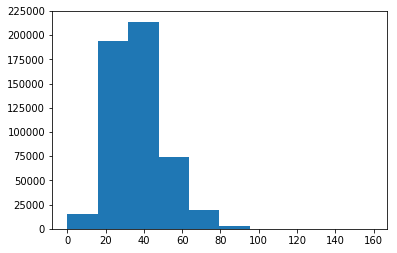

In [17]:
import matplotlib.pyplot as plt

plt.hist(age)
plt.show()

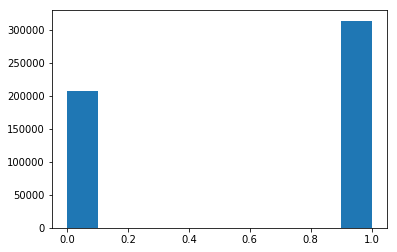

In [18]:
plt.hist(sex)
plt.show()

In [19]:
# save to hdf

import h5py

f = h5py.File(hdf_path, mode='w')
img_dset = f.create_dataset('img', data=img)
sex_dset = f.create_dataset('sex', data=sex)
age_dset = f.create_dataset('age', data=age)
f.flush()
f.close()

In [20]:
# read from hdf
f_read = h5py.File(hdf_path, mode='r')

img_read = f_read['img']
age_read = f_read['age']
sex_read = f_read['sex']
img_read.shape, age_read.shape, sex_read.shape

((520955, 30, 30, 3), (520955,), (520955,))

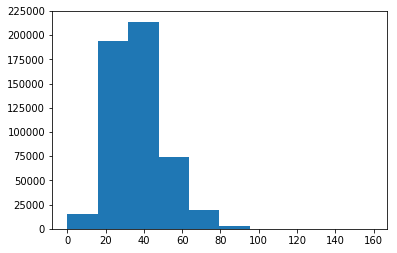

In [21]:
plt.hist(age_read)
plt.show()

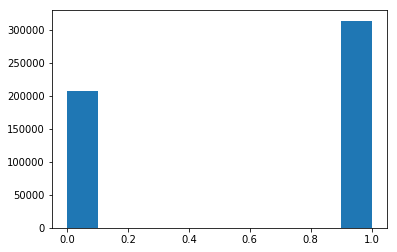

In [22]:
plt.hist(sex_read)
plt.show()

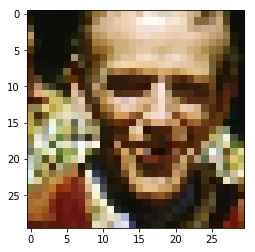

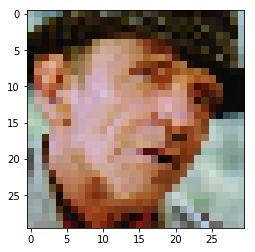

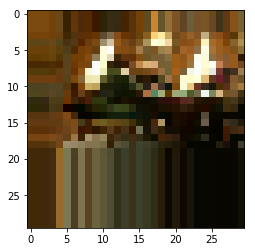

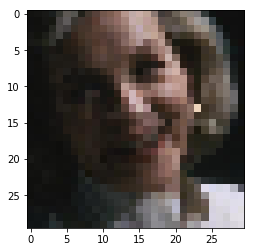

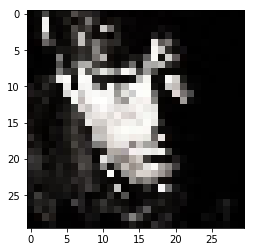

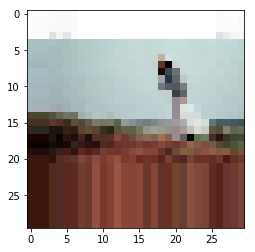

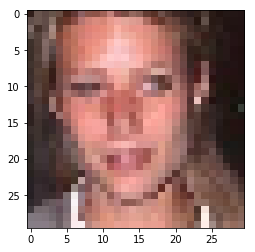

In [23]:
for i in [0,3,30,31,1000,1500,2000-1]:
    plt.imshow(img_read[i])
    plt.show()

In [24]:
f_read.flush()
f_read.close()